# Earth

In [1]:
!pip install -U -q netcdf4 xarray pytype google-cloud-storage pyresample

from google.colab import auth
auth.authenticate_user()

     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 532kB 47.7MB/s 
     |████████████████████████████████| 1.0MB 45.1MB/s 
     |████████████████████████████████| 71kB 27.4MB/s 
     |████████████████████████████████| 4.1MB 51.5MB/s 
     |████████████████████████████████| 307kB 61.5MB/s 
     |████████████████████████████████| 102kB 33.9MB/s 
     |████████████████████████████████| 737kB 56.0MB/s 
     |████████████████████████████████| 10.8MB 47.3MB/s 
     |████████████████████████████████| 81kB 30.0MB/s 


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import Any, Callable, Dict, List, Optional, Text, Tuple, Union

import collections
from contextlib import contextmanager
import datetime
import dateutil.tz
import itertools
import matplotlib.pyplot as plt
import netCDF4  # netCDF4 *must* be imported before tensorflow
import numpy as np
import logging
import os
import pyresample
import re
import skimage 
import skimage.transform
import tempfile
import tensorflow as tf
from tensorflow import keras
import time
import urllib
import xarray

import google.cloud.storage as gcs

PROJECT_ID = 'weather-324'
GOES_BUCKET = 'gcp-public-data-goes-16'
UTC = dateutil.tz.tzutc()

# https://visibleearth.nasa.gov/view.php?id=73909
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x10800.png'
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

# Metadata fields to save from each imager file.
METADATA_KEYS = [
    'x',
    'y',
    'kappa0',
    'band_id',
    'x_image_bounds',
    'y_image_bounds',
    'goes_imager_projection',
    'time_coverage_start',
]

TRAIN_PATH = 'gs://weather-datasets/goes_truecolor/examples/train.tfrecord*'
TEST_PATH = 'gs://weather-datasets/goes_truecolor/examples/test.tfrecord*'

TMP_DIR = tempfile.mkdtemp('Truecolor_2')

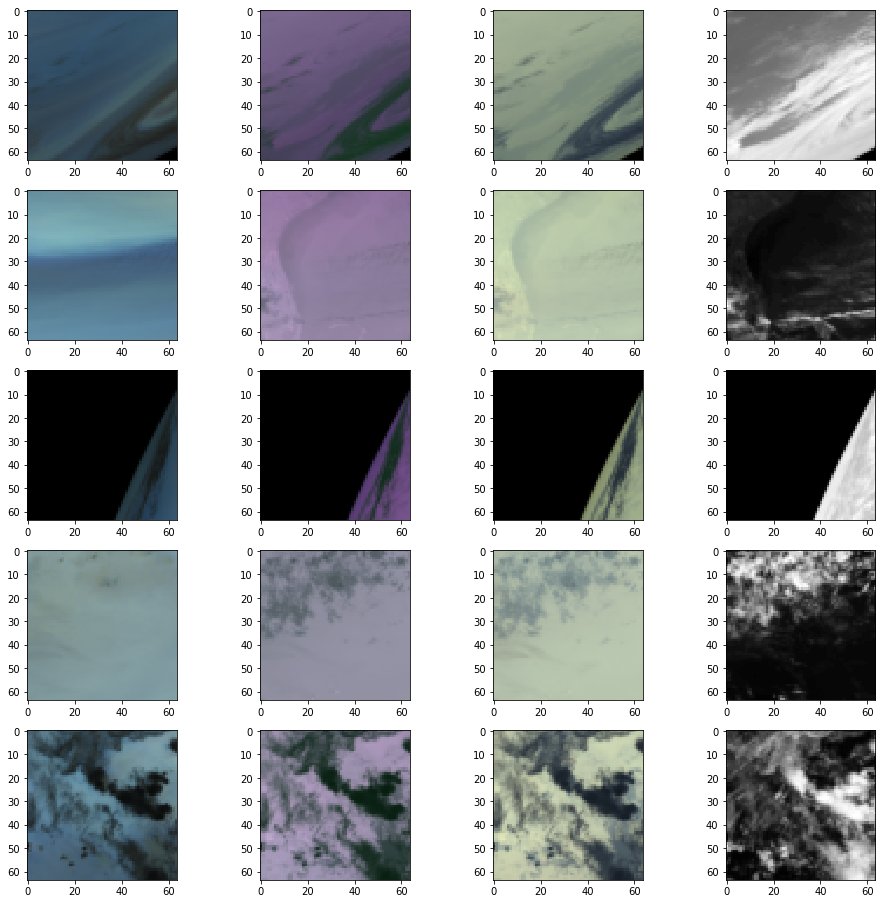

In [3]:
MAX_COLOR_VALUE = 255.9

CLOUD_MASK_FEATURE_NAME = 'cloud-mask'
IR_CHANNELS_FEATURE_NAME = 'ir-channels'

def make_dataset(
    pattern: Text,
    tile_size: int = 64,
    batch_size: int = 8,
    num_map_threads: int = 16,
    mode: tf.estimator.ModeKeys = tf.estimator.ModeKeys.TRAIN) -> tf.data.Dataset:
  """Create a dataset.
  
  Args:
    pattern: file input pattern.
    tile_size: size of the input tiles.
    
  Returns:
    A tf.data.Dataset
  """
  example_fmt = {
      CLOUD_MASK_FEATURE_NAME: tf.FixedLenFeature(
        (tile_size, tile_size, 1), tf.int64),
      IR_CHANNELS_FEATURE_NAME: tf.FixedLenFeature(
        (tile_size, tile_size, 9), tf.int64),
  }

  def parse_fn(example: Text) -> Tuple[Dict[Text, tf.Tensor], tf.Tensor]:
    parsed = tf.parse_single_example(example, example_fmt)
    raster_in_img = parsed[IR_CHANNELS_FEATURE_NAME]
    raster_out_img = parsed[CLOUD_MASK_FEATURE_NAME]
    raster_in_img = tf.cast(raster_in_img, tf.float32) / 256
    raster_out_img = tf.cast(raster_out_img, tf.float32) / 256
    return raster_in_img, raster_out_img

  is_training = mode == tf.estimator.ModeKeys.TRAIN
  ds = tf.data.Dataset.list_files(pattern, shuffle=is_training)
  ds = ds.repeat()
  ds = ds.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=8)
  ds = ds.shuffle(batch_size * 16)
  ds = ds.map(map_func=parse_fn, num_parallel_calls=num_map_threads)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(32)
  return ds

def print_dataset(pattern):
  ds = make_dataset(pattern)  
  next = ds.make_one_shot_iterator().get_next()
  
  plt.figure(figsize=(16, 16))
  with tf.Session() as sess:
    sess = tf.Session()
    raster_in_img, raster_out_img = sess.run(next)
    raster_in_img = (raster_in_img[0:5, :, :, :] * MAX_COLOR_VALUE).astype(np.uint8)
    raster_out_img = (raster_out_img * MAX_COLOR_VALUE).astype(np.uint8)
    for i in range(5):
      for j in range(3):
        ax = plt.subplot(5, 4, i * 4 + j + 1)
        ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
      ax = plt.subplot(5, 4, i * 4 + 4)
      ax.imshow(raster_out_img[i, :, :, 0], cmap='gray')
  plt.show()
  
print_dataset(TRAIN_PATH)  

In [0]:
def default_hparams(**kwargs: Any) -> tf.contrib.training.HParams:
  """Create default hyper-parameters for training a model.

  Args:
    **kwargs: default hyper-parameter values to override.

  Returns:
    HParams object with all hyperparameter values.
  """
  hparams = tf.contrib.training.HParams(
      model_dir='gs://weather-datasets/model',
      train_data_path=TRAIN_PATH,
      eval_data_path=TEST_PATH,
      train_batch_size=32,
      learning_rate=1e-3,
      train_steps=20000,
      num_eval_records=128,
      num_cores=8,
      tile_size=64,
      
      # CNN
      kernel_size=5,
      num_filters=16,
      num_layers=3,
  )
  hparams.override_from_dict(kwargs)
  return hparams

hparams = default_hparams()

In [23]:
def create_model(hparams: tf.contrib.training.HParams, img: tf.Tensor) -> tf.Tensor:
  kernel_size = hparams.kernel_size
  num_filters = hparams.num_filters
  num_layers = hparams.num_layers
  cnn = keras.layers.BatchNormalization()(img)
  for layer in range(num_layers):
    cnn = keras.layers.Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(cnn)
    cnn = keras.layers.Activation('elu')(cnn)
    cnn = keras.layers.BatchNormalization()(cnn)
  cnn = keras.layers.Conv2D(1, (kernel_size, kernel_size), padding='same')(cnn)
  cnn = keras.layers.Activation('relu')(cnn)
  return cnn

def train_and_evaluate(hparams: tf.contrib.training.HParams) -> keras.Model:
  model_dir = hparams.model_dir
  max_steps = hparams.train_steps
  
  # Limit the epoch size.
  steps_per_epoch = min(1000, max_steps // 10)
  num_epochs = max(1, max_steps // steps_per_epoch)
  
  # eval batch size has to be divisible by num_cores
  eval_batch_size = min(hparams.num_eval_records, hparams.train_batch_size)
  eval_batch_size = eval_batch_size - eval_batch_size % hparams.num_cores
  eval_steps = hparams.num_eval_records // eval_batch_size
  tf.logging.info('train_batch_size=%d eval_batch_size=%d train_steps=%d (%d x %d) eval_steps=%d',
                  hparams.train_batch_size, eval_batch_size,
                  max_steps, steps_per_epoch, num_epochs,
                  eval_steps)
  
  # Build the model
  input_img = keras.Input(shape=(hparams.tile_size, hparams.tile_size, 9))
  cnn = create_model(hparams, input_img)
  model = keras.Model(input_img, cnn)
  optimizer = keras.optimizers.Adam(lr=hparams.learning_rate, clipnorm=1.)
  model.compile(optimizer=optimizer,
                loss=keras.losses.mean_absolute_error,
                metrics=['accuracy', 'mse'])

  # Make the datasets
  train_ds = make_dataset(
      hparams.train_data_path,
      mode=tf.estimator.ModeKeys.TRAIN,
      batch_size=hparams.train_batch_size)
  eval_ds = make_dataset(
      hparams.eval_data_path,
      mode=tf.estimator.ModeKeys.EVAL,
      batch_size=eval_batch_size)
  
  # train and evaluate
  start_timestamp = time.time()
  history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=eval_ds,
    validation_steps=eval_steps,
    verbose=1 # 1=progress 2=one line per epoch
  )
  elapsed_time = int(time.time() - start_timestamp)
  tf.logging.info('Finished training up to step %d. Elapsed seconds %d.',
                  max_steps, elapsed_time)
  # tf.logging.info(model.summary())
  print("if running interactively, graph: {}".format(history.history.keys()))
  
  return model

model = train_and_evaluate(hparams)

INFO:tensorflow:train_batch_size=32 eval_batch_size=32 train_steps=20000 (1000 x 20) eval_steps=4
Epoch 1/20
1000/1000 [==============================] - 69s 69ms/step - loss: 3.1617 - acc: 0.2208 - mean_squared_error: 0.0230 - val_loss: 4.2740 - val_acc: 0.1571 - val_mean_squared_error: 0.0308
Epoch 2/20
1000/1000 [==============================] - 73s 73ms/step - loss: 2.5633 - acc: 0.2113 - mean_squared_error: 0.0139 - val_loss: 2.3998 - val_acc: 0.1795 - val_mean_squared_error: 0.0114
Epoch 3/20
1000/1000 [==============================] - 59s 59ms/step - loss: 2.3384 - acc: 0.2163 - mean_squared_error: 0.0115 - val_loss: 2.4330 - val_acc: 0.2136 - val_mean_squared_error: 0.0127
Epoch 4/20
1000/1000 [==============================] - 59s 59ms/step - loss: 2.1492 - acc: 0.2172 - mean_squared_error: 0.0099 - val_loss: 2.3989 - val_acc: 0.2047 - val_mean_squared_error: 0.0111
Epoch 5/20
1000/1000 [==============================] - 55s 55ms/step - loss: 2.0542 - acc: 0.2188 - mean_squa

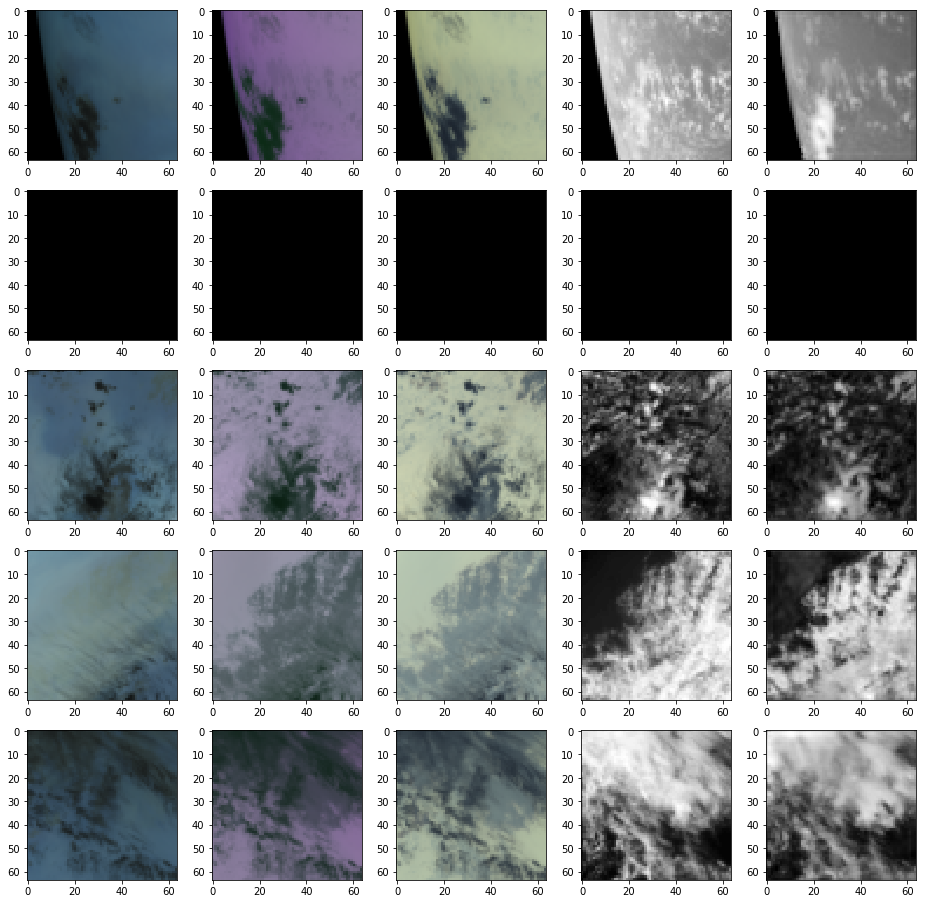

In [24]:
def show_prediction(model: keras.Model, hparams: tf.contrib.training.HParams):
  batch_size = 8
  ds = make_dataset(TRAIN_PATH, batch_size=batch_size)  
  next = ds.make_one_shot_iterator().get_next()
  with tf.Session() as sess:
    sess = tf.Session()
    raster_in_img, raster_out_img = sess.run(next)
  predict_out_img = model.predict(raster_in_img)
  
  plt.figure(figsize=(16, 16))
  for i in range(5):
    for j in range(3):
      ax = plt.subplot(5, 5, i * 5 + j + 1)
      ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
    ax = plt.subplot(5, 5, i * 5 + 4)
    ax.imshow(raster_out_img[i, :, :, 0], cmap='gray')
    ax = plt.subplot(5, 5, i * 5 + 5)
    ax.imshow(predict_out_img[i, :, :, 0], cmap='gray')
    
show_prediction(model, hparams)

In [25]:
def export_keras(model: keras.Model, hparams: tf.contrib.training.HParams) -> Text:
  export_path = tf.contrib.saved_model.save_keras_model(
      model, os.path.join(hparams.model_dir, 'export/exporter'))
  export_path = export_path.decode('utf-8')
  tf.logging.info('Model exported successfully to %s', export_path)
  return export_path
  
export_path = export_keras(model, hparams)


Consider using a TensorFlow optimizer from `tf.train`.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://weather-datasets/model/export/exporter/1557943804/saved_model.pb
INFO:tensorflow:Model exported successfully to gs://weather-datasets/model/export/exporter/1557943804


INFO:tensorflow:Loading model from gs://weather-datasets/model/export/exporter/1557934943


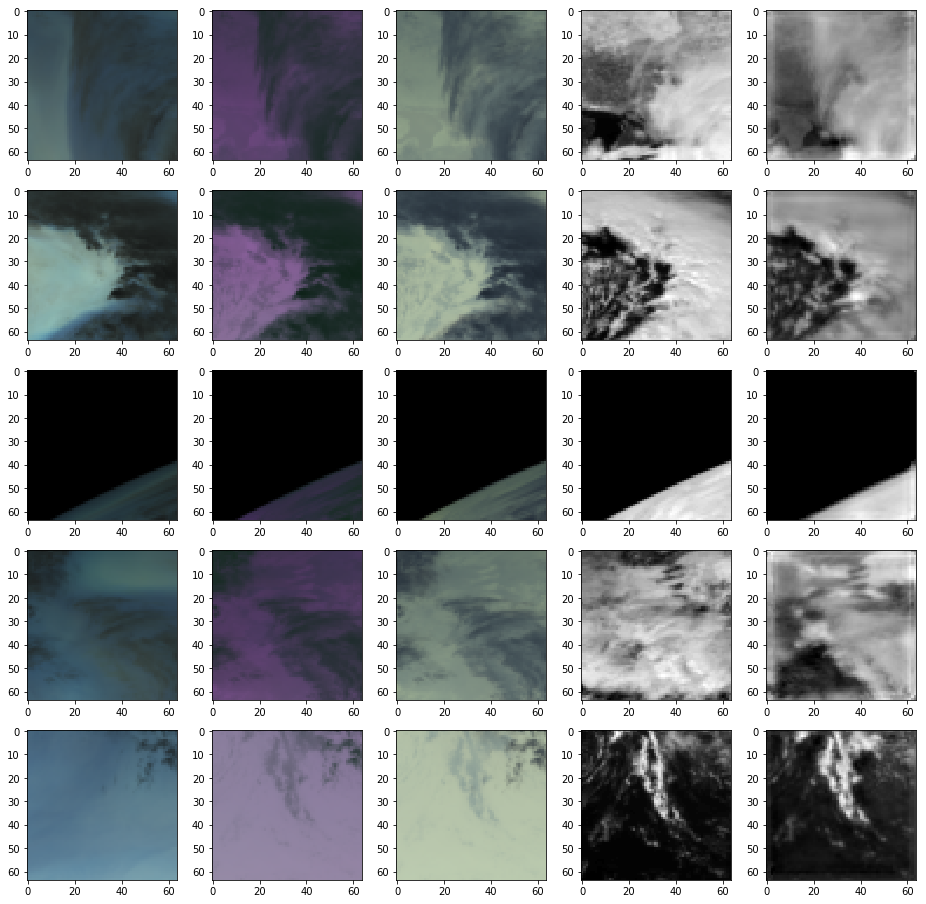

In [11]:
def show_prediction_from_saved_model(model_file: Text, hparams: tf.contrib.training.HParams):
  tf.logging.info('Loading model from %s', model_file)
  saved_model = tf.contrib.saved_model.load_keras_model(model_file)
  
  batch_size = 8
  ds = make_dataset(TRAIN_PATH, batch_size=batch_size)  
  next = ds.make_one_shot_iterator().get_next()
  with tf.Session() as sess:
    sess = tf.Session()
    raster_in_img, raster_out_img = sess.run(next)
  
  predict_out_img = saved_model.predict(raster_in_img)
  
  plt.figure(figsize=(16, 16))
  for i in range(5):
    for j in range(3):
      ax = plt.subplot(5, 5, i * 5 + j + 1)
      ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
    ax = plt.subplot(5, 5, i * 5 + 4)
    ax.imshow(raster_out_img[i, :, :, 0], cmap='gray')
    ax = plt.subplot(5, 5, i * 5 + 5)
    ax.imshow(predict_out_img[i, :, :, 0], cmap='gray')
    
show_prediction_from_saved_model(export_path, hparams)